In [2]:
import pandas as pd
import os

In [4]:
data_folder = "../cleaned_data/electricity_trading/"
df = pd.read_pickle(f"{data_folder}/germany_power_mw_2015_2023_tcs_saldo.xz")

In [5]:
df.columns

Index(['AT', 'CZ', 'DK', 'FR', 'LU', 'NL', 'PL', 'SE', 'CH', 'year', 'hour',
       'BE', 'NO'],
      dtype='object')

### 1.1. Overview on import/exports in Germany

Text(0.5, 1.0, 'Overview on imports and exports in German electricity market 2015 - 2023')

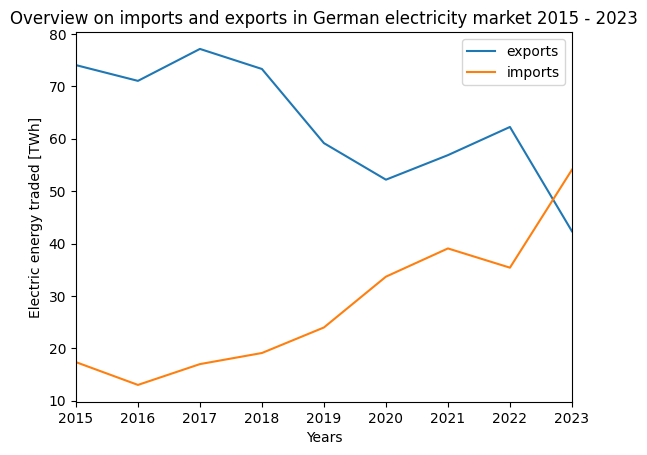

In [8]:
exports = -(df[df<0]/4e6).drop(columns=["year", "hour"]).groupby(pd.Grouper(freq="1y")).sum().sum(axis=1)
imports = (df[df>0]/4e6).drop(columns=["year", "hour"]).groupby(pd.Grouper(freq="1y")).sum().sum(axis=1)

ax = pd.DataFrame({"exports": exports, "imports": imports}).plot.line()
ax.set_xlabel("Years")
ax.set_ylabel("Electric energy traded [TWh]")
ax.set_title("Overview on imports and exports in German electricity market 2015 - 2023")

Matches official numbers by Bundesnetzagentur 54.1 TWh Import and 42.4 TWh Exports

https://www.bundesnetzagentur.de/SharedDocs/Pressemitteilungen/EN/2024/20240103_SMARD.html

### 1.2. Read energy production data in countries importing energy to Germany

In [9]:
country_dfs = {}

In [10]:
for col in df.columns:
    if col in ["year", "hour"]:
        continue
    country_dfs[col] = pd.read_pickle(f"{data_folder}/{col}_power_mw_2015_2023_public.xz").resample("15min").interpolate().drop(columns=["year", "hour", "Load", "Residual load"])

### 1.3. Reading german energy production data

In [12]:
german_prod = pd.read_pickle(f"{data_folder}/../german_grid_history/germany_power_mw_2010_2023_public.xz").loc["2015":"2023"]

### 1.4. Create relevant column names

In [13]:
fossil_cols = ["Fossil hard coal", "Fossil oil", "Fossil gas", "Others", "Fossil brown coal / lignite"]
renew_cols = ["Hydro", "Waste", "Wind onshore", "Wind offshore", "Solar", "Biomass", "Geothermal", "Other renewables"]
nuclear_cols = ["Nuclear"]

In [14]:
cols = fossil_cols + renew_cols + nuclear_cols

### 2.1. Understand import/exports by energy source

In [15]:
res_table = []
for country in country_dfs.keys():
    t_import = (df[country]>0)
    gen_cols = list(set(cols).intersection(set(country_dfs[country].columns)))
    generation_ratios = country_dfs[country][gen_cols].divide(country_dfs[country][gen_cols].sum(axis=1), axis=0)
    
    gen_imports = (generation_ratios.loc[t_import].multiply(df[country].loc[t_import], axis=0)).groupby(pd.Grouper(freq="1y")).sum()
    res_table.append(gen_imports.reset_index())

import_types = pd.concat(res_table).groupby("index").sum()/4e6

In [16]:
res_table3 = {}
prod_cols = list(set(cols).intersection(set(german_prod.columns)))
generation_ratios = german_prod.divide(german_prod[prod_cols].sum(axis=1), axis=0)

for country in country_dfs.keys():
    t_export = (df[country]<0)    
    gen_imports = generation_ratios.loc[t_export].multiply(df[country].loc[t_export], axis=0).groupby(pd.Grouper(freq="1y")).sum()
    res_table3[country] = gen_imports.reset_index()
    
export_types = -pd.DataFrame(pd.concat(res_table3)).groupby("index").sum()/4e6

In [17]:
imports = pd.DataFrame({"Renewables": import_types[renew_cols].sum(axis=1),
                        "Nuclear": import_types["Nuclear"],
                        "Fossils": import_types[fossil_cols].sum(axis=1)})

exports = pd.DataFrame({"Renewables": export_types[list(set(renew_cols) - set(["Other renewables"]))].sum(axis=1),
                        "Nuclear": export_types["Nuclear"],
                        "Fossils": export_types[fossil_cols].sum(axis=1)})

### 2.2. Chart import/exports by energy source

Text(0.5, 1.0, 'Overview on imported electricity [TWh] by type of energy source 2015 - 2023')

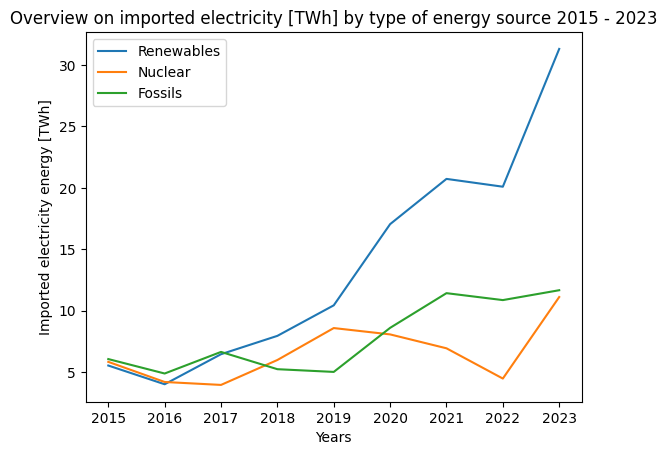

In [21]:
imports.index = list(range(2015, 2024))
ax = imports.plot.line()
ax.set_xlabel("Years")
ax.set_ylabel("Imported electricity energy [TWh]")
ax.set_title("Overview on imported electricity [TWh] by type of energy source 2015 - 2023")

Text(0.5, 1.0, 'Overview on exported electricity [TWh] by type of energy source 2015 - 2023')

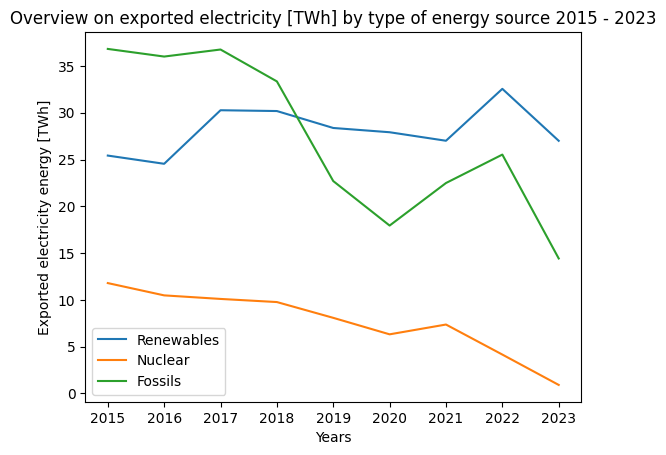

In [22]:
exports.index = list(range(2015, 2024))
ax = exports.plot.line()
ax.set_xlabel("Years")
ax.set_ylabel("Exported electricity energy [TWh]")
ax.set_title("Overview on exported electricity [TWh] by type of energy source 2015 - 2023")

Text(0.5, 1.0, 'Overview on exported - imported electricity [TWh] by type of energy source 2015 - 2023')

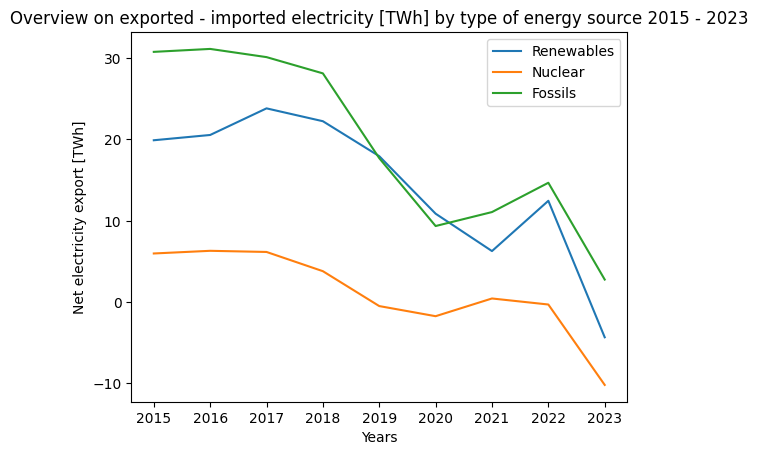

In [23]:
balance = exports - imports
ax = balance.plot.line()
ax.set_xlabel("Years")
ax.set_ylabel("Net electricity export [TWh]")
ax.set_title("Overview on exported - imported electricity [TWh] by type of energy source 2015 - 2023")

### 4.1 Time patterns of export [hour]

In [75]:
res_table4 = {}
generation_ratios = german_prod.divide(german_prod[list(set(cols).intersection(german_prod.columns))].sum(axis=1), axis=0).loc["2023"]

for country in country_dfs.keys():
    t_export = (df[country].loc["2023"]<0)
    gen_imports = generation_ratios.loc[t_export].multiply(df[country].loc["2023"].loc[t_export], axis=0)

    for col in cols:
        if col not in gen_imports.columns:
            continue
        if col in res_table4.keys():
            res_table4[col] += gen_imports[col].groupby(gen_imports[col].index.hour).sum()/4e6
        else:
            res_table4[col] = gen_imports[col].groupby(gen_imports[col].index.hour).sum()/4e6

<Axes: >

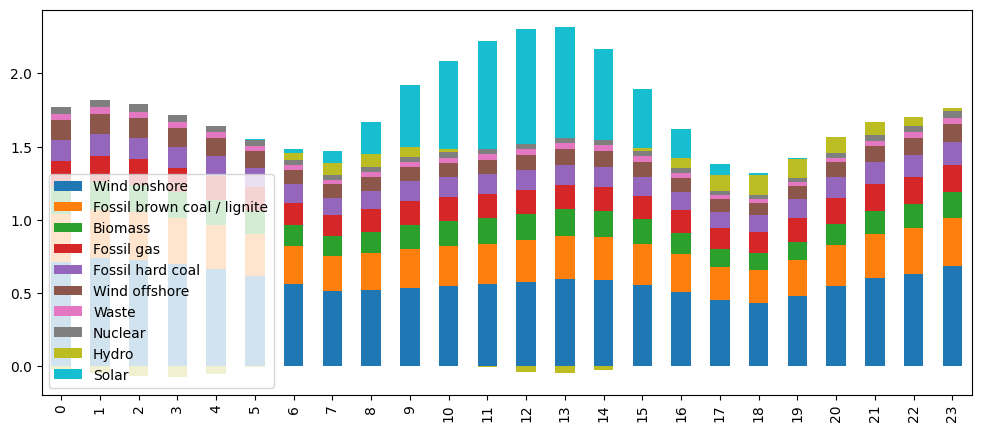

In [78]:
hourly_exports = (-pd.DataFrame(res_table4))[(-pd.DataFrame(res_table4)).median(axis=0).sort_values().index[:-11:-1]]
hourly_exports.plot.bar(stacked=True,figsize=(12, 5))

### 4.2 Time patterns of export [day of week]

In [72]:
res_table4 = {}
generation_ratios = german_prod.divide(german_prod[list(set(cols).intersection(german_prod.columns))].sum(axis=1), axis=0).loc["2023"]

for country in country_dfs.keys():
    t_export = (df[country].loc["2023"]<0)
    gen_imports = generation_ratios.loc[t_export].multiply(df[country].loc["2023"].loc[t_export], axis=0)

    for col in cols:
        if col not in gen_imports.columns:
            continue
        if col in res_table4.keys():
            res_table4[col] += gen_imports[col].groupby(gen_imports[col].index.dayofweek).sum()/4e6
        else:
            res_table4[col] = gen_imports[col].groupby(gen_imports[col].index.dayofweek).sum()/4e6

<Axes: >

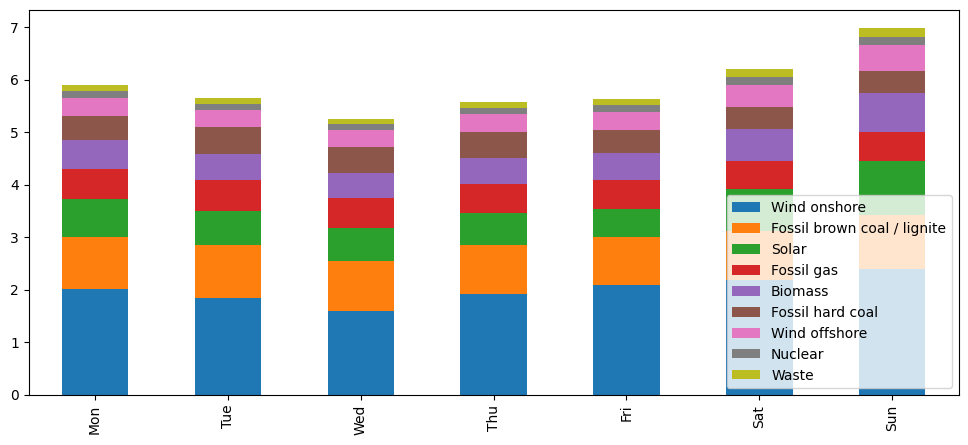

In [74]:
daily_exports = (-pd.DataFrame(res_table4))[(-pd.DataFrame(res_table4)).median(axis=0).sort_values().index[:-10:-1]]
daily_exports.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
daily_exports.plot.bar(stacked=True,figsize=(12, 5))

<Axes: >

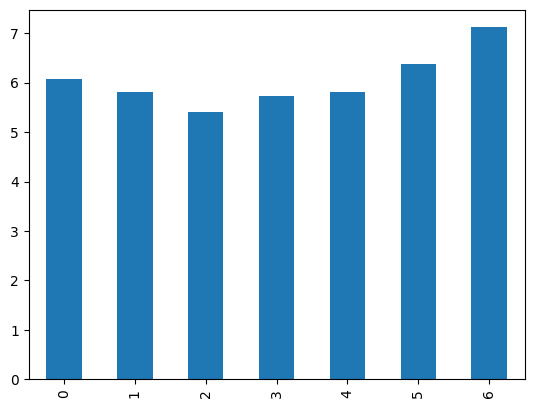

In [114]:
(-pd.DataFrame(res_table4)).sum(axis=1).plot.bar()

### 4.3 Time patterns of export [month]

In [65]:
res_table4 = {}
generation_ratios = german_prod.divide(german_prod[list(set(cols).intersection(german_prod.columns))].sum(axis=1), axis=0).loc["2023"]

for country in country_dfs.keys():
    t_export = (df[country].loc["2023"]<0)
    gen_imports = generation_ratios.loc[t_export].multiply(df[country].loc["2023"].loc[t_export], axis=0)

    for col in cols:
        if col not in gen_imports.columns:
            continue
        if col in res_table4.keys():
            res_table4[col] += gen_imports[col].groupby(gen_imports[col].index.month).sum()/4e6
        else:
            res_table4[col] = gen_imports[col].groupby(gen_imports[col].index.month).sum()/4e6

In [66]:
(-pd.DataFrame(res_table4)).median(axis=0).sort_values()

Nuclear                        0.000000
Geothermal                     0.001245
Others                         0.014561
Fossil oil                     0.025295
Hydro                          0.055174
Waste                          0.071803
Wind offshore                  0.215472
Fossil hard coal               0.225907
Fossil gas                     0.295407
Biomass                        0.312531
Solar                          0.379702
Fossil brown coal / lignite    0.577813
Wind onshore                   1.086386
dtype: float64

<Axes: >

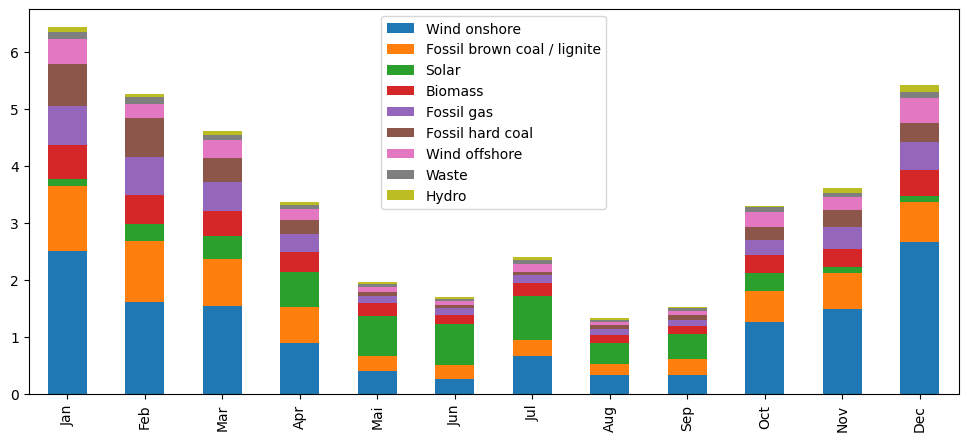

In [71]:
monthly_exports = (-pd.DataFrame(res_table4))[(-pd.DataFrame(res_table4)).median(axis=0).sort_values().index[:-10:-1]]
monthly_exports.index = ["Jan", "Feb", "Mar", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_exports.plot.bar(stacked=True,figsize=(12, 5))

<Axes: >

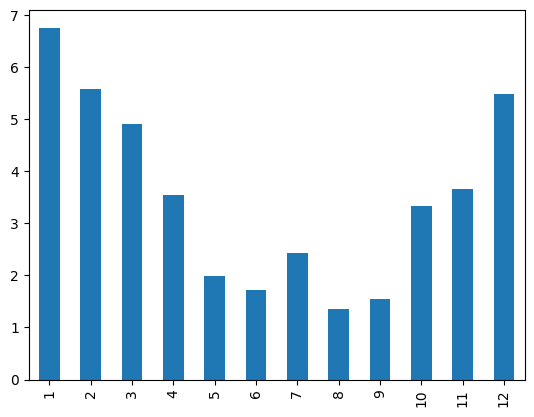

In [117]:
(-pd.DataFrame(res_table4)).sum(axis=1).plot.bar()